# Black - Scholes - Merton Model: Pricing, parity, greeks e IV

## 0 - Set up ambiente

In [2]:
import os, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Imposto la root del progetto a partire dalla posizione di questo file
PROJECT_ROOT = Path.cwd().parent
SRC_DIR = PROJECT_ROOT / "src"
DATA_RESULTS = PROJECT_ROOT / "data" / "results"
DATA_RESULTS.mkdir(parents=True, exist_ok=True)

# Aggiungo la cartella src al path per poter importare i moduli personalizzati
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from bsm import bs_price, bs_greeks, implied_vol
from utils_plot import plot_paths

## 1 - Definizio dei parametri base

In [3]:
S0 = 100.0   # spot
K  = 100.0   # strike
T  = 1.0     # anni
r  = 0.02    # risk-free
q  = 0.00    # dividendo continuo
sigma = 0.20 # volatilità

## 2 - Prezzi Call/Put + Parità

In [4]:
c = bs_price(S0, K, T, r, sigma, q, kind="call")
p = bs_price(S0, K, T, r, sigma, q, kind="put")

# Calcola il lato sinistro (lhs) della parità put-call, che è dato dalla differenza tra il prezzo della call (c) e il prezzo della put (p)
lhs = c - p
# Calcola il lato destro (rhs) della parità put-call, che è dato dalla differenza tra il valore attuale del sottostante (S0 scontato al tasso di dividendo q) e il valore attuale del prezzo di esercizio (K scontato al tasso risk-free r)
rhs = S0*np.exp(-q*T) - K*np.exp(-r*T)

print(f"Call C = {c:.6f}  |  Put P = {p:.6f}")
print(f"Parità put–call → diff = {(lhs - rhs):.3e}")


Call C = 8.916037  |  Put P = 6.935905
Parità put–call → diff = -7.105e-15


# 3 -  Greche vs Spot S

+ Utile per capire la sensibilità rispetto al sottostante; grafici chiari e “didattici”.
+ Vettorizzo su S_grid.
+ Uso bs_greeks(..., kind="call").
+ Grafici separati per Δ, Γ, 𝒱, Θ, ρ.

Aspettativa:
+ Delta(call): cresce ~ da 0→1.
+ Gamma: picco vicino a ATM.
+ Vega: massimo vicino a ATM e a T medi.
+ Theta(call): spesso negativo, più forte intorno ad ATM.
+ Rho(call): positivo.

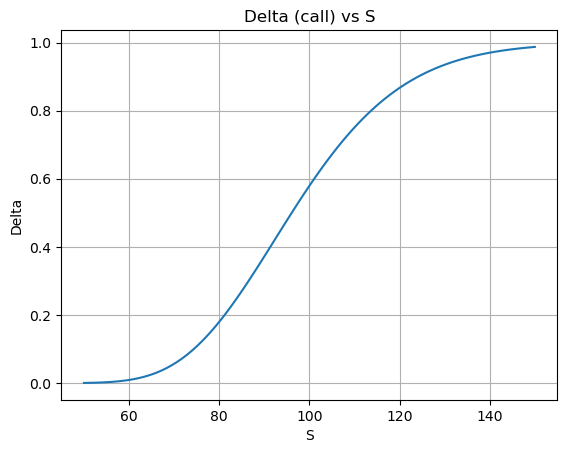

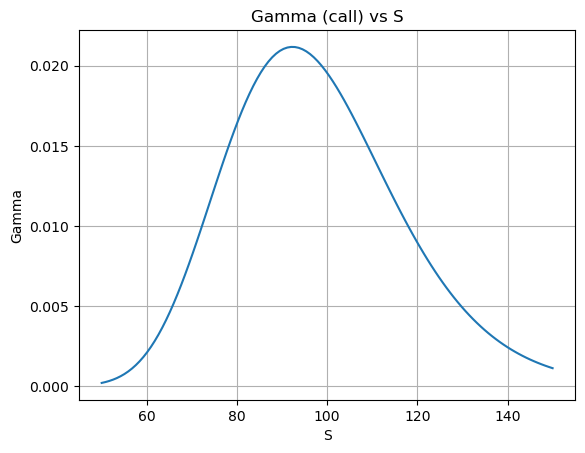

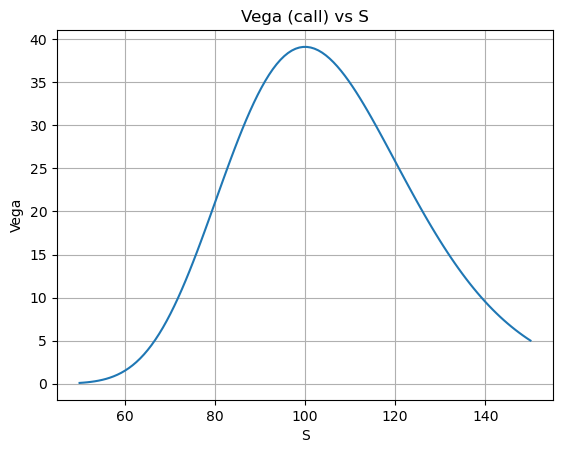

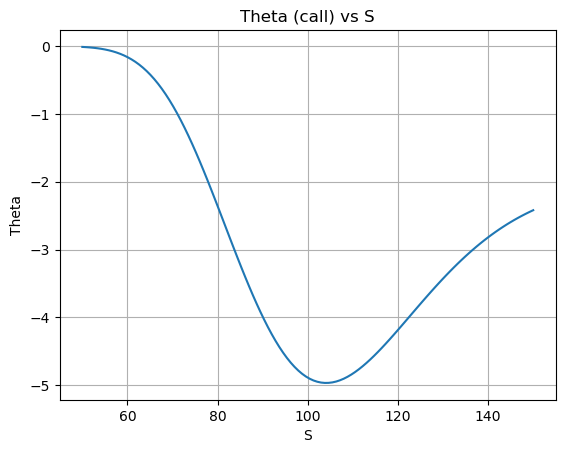

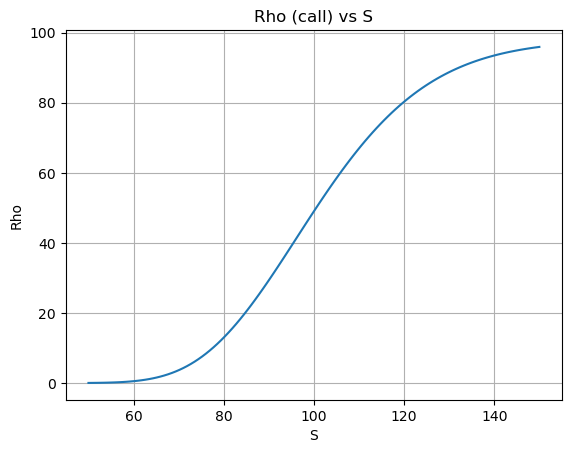

In [5]:
S_grid = np.linspace(50, 150, 120)
G = bs_greeks(S_grid, K, T, r, sigma, q, kind="call")

for name in ["delta", "gamma", "vega", "theta", "rho"]:
    plt.figure()
    plt.plot(S_grid, G[name])
    plt.title(f"{name.capitalize()} (call) vs S")
    plt.xlabel("S"); plt.ylabel(name.capitalize()); plt.grid(True)


## 4 - Greche vs Volatilità

Mostra l’effetto della volatilità su curvature e time decay.
+ Fisso S=K.
+ Varia sigma in griglia.
+ Plotto Vega, Gamma, Theta.

Aspettativa:
+ Vega aumenta con T e picca ATM; vs σ ha forma “campana larga”.
+ Gamma decresce al crescere di σ (gamma più “spigolosa” con bassa σ).
+ Theta (call) diventa più negativo intorno a ATM con σ medio/alto.

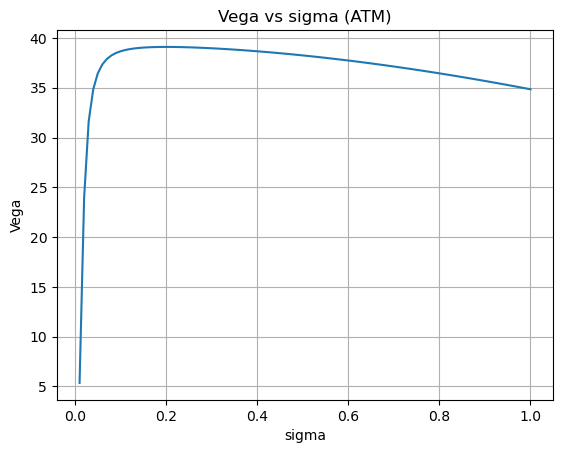

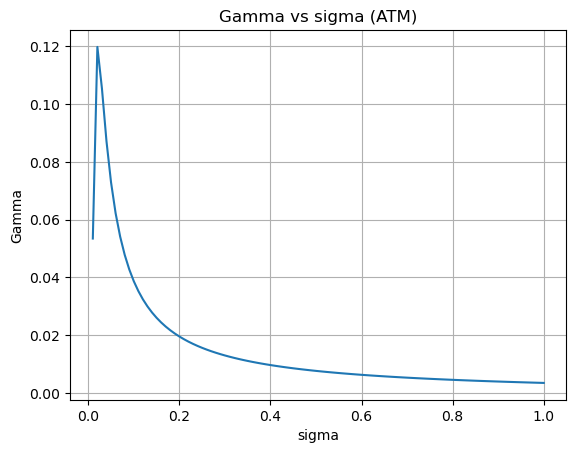

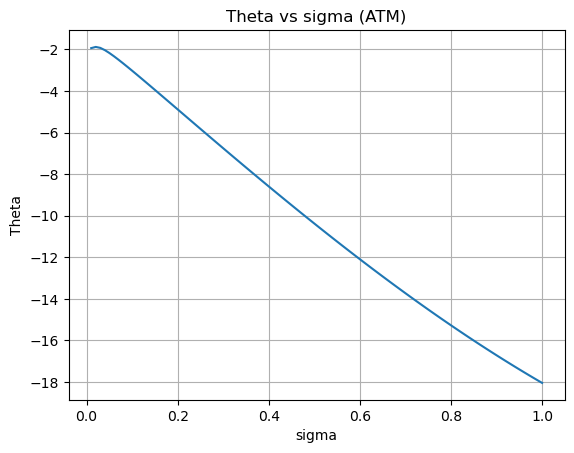

In [6]:
sig_grid = np.linspace(0.01, 1.0, 100)
Gsig = bs_greeks(S0, K, T, r, sig_grid, q, kind="call")

for name in ["vega", "gamma", "theta"]:
    plt.figure()
    plt.plot(sig_grid, Gsig[name])
    plt.title(f"{name.capitalize()} vs sigma (ATM)")
    plt.xlabel("sigma"); plt.ylabel(name.capitalize()); plt.grid(True)
    plt.savefig(DATA_RESULTS / f"bsm_{name}_vs_sigma.png", dpi=150)


## 5 -Implied Volatility: caso singolo + vettoriale su strike

+ Validare l’inversa e mostrare che la IV recupera la σ usata.
+ Calcolo prezzo teorico call e tiro fuori IV (attesa ~ sigma).
+ Griglia di strike, calcolo prezzi e poi IV per ciascuno (smile “numerico”).

Aspettativa: 
+ IV ~ costante ~ sigma (poiché i prezzi sono “coerenti di fabbrica”).
+ Nota robustezza: la tua implied_vol controlla bounds no-arb e brent; se qualcosa è fuori, torna NaN (giusto così).

In [7]:
import importlib, bsm
importlib.reload(bsm)
from bsm import bs_price, implied_vol

In [8]:
# singolo
c_theo = bs_price(S0, K, T, r, sigma, q, kind="call")
iv = implied_vol(c_theo, S0, K, T, r, q, kind="call")
print(f"IV stimata = {iv:.6f} (atteso ~{sigma:.2f})")

# vettoriale
K_grid = np.linspace(60, 140, 9)
prices = bs_price(S0, K_grid, T, r, sigma, q, kind="call")
iv_grid = implied_vol(prices, S0, K_grid, T, r, q, kind="call")
print(np.c_[K_grid, prices, iv_grid])


IV stimata = 0.200000 (atteso ~0.20)
[[ 60.          41.20687441   0.2       ]
 [ 70.          31.57655031   0.2       ]
 [ 80.          22.54285316   0.2       ]
 [ 90.          14.80650702   0.2       ]
 [100.           8.91603728   0.2       ]
 [110.           4.94386696   0.2       ]
 [120.           2.54692626   0.2       ]
 [130.           1.2320276    0.2       ]
 [140.           0.56550514   0.2       ]]


## 6 - Stress test numerici

+ utile nella tesi per discutere stabilità.
+ Edge: T → 0, sigma → 0, deep ITM/OTM.
+ Mostrare che:
+ + per T≈0 → prezzo ≈ payoff intrinseco; greek possono “esplodere”.
+ + per sigma≈0 → prezzo ≈ max(S e^{-qT} - K e^{-rT}, 0) con greche “spigolose”.

In [9]:
# esempio T→0
eps_T = 1e-6
c_epsT = bs_price(S0, K, eps_T, r, sigma, q, kind="call")
print("T→0: C ≈", c_epsT, "  payoff_intrinseco:", max(S0 - K, 0))

# esempio sigma→0
eps_sigma = 1e-6
c_epssigma = bs_price(S0, K, T, r, eps_sigma, q, kind="call")
print("sigma→0: C ≈ max(S0 e^{-qT} - K e^{-rT}, 0) =", c_epssigma, "  payoff_intrinseco:", max(S0*np.exp(-q*T) - K*np.exp(-r*T), 0))

T→0: C ≈ 0.007979845554821452   payoff_intrinseco: 0.0
sigma→0: C ≈ max(S0 e^{-qT} - K e^{-rT}, 0) = 1.980132669324476   payoff_intrinseco: 1.980132669324476


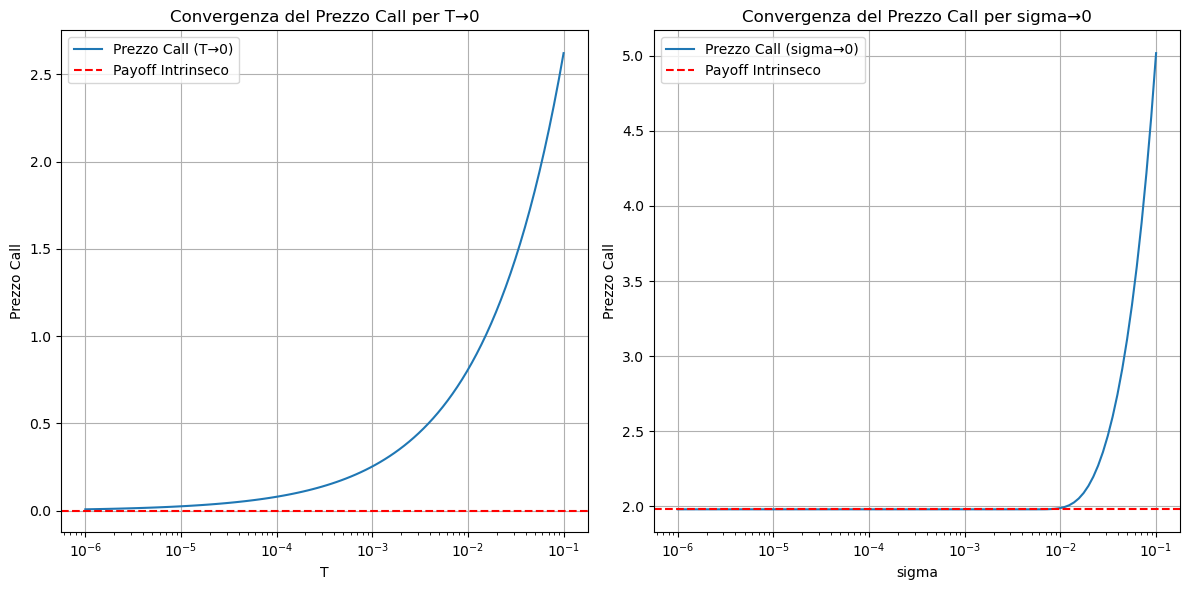

In [10]:
# Calcolo per T→0
eps_T_values = np.logspace(-6, -1, 100)  # valori di T che si avvicinano a 0
c_epsT_values = [bs_price(S0, K, T_val, r, sigma, q, kind="call") for T_val in eps_T_values]

# Calcolo per sigma→0
eps_sigma_values = np.logspace(-6, -1, 100)  # valori di sigma che si avvicinano a 0
c_epssigma_values = [bs_price(S0, K, T, r, sigma_val, q, kind="call") for sigma_val in eps_sigma_values]

# Grafico
plt.figure(figsize=(12, 6))

# Grafico per T→0
plt.subplot(1, 2, 1)
plt.plot(eps_T_values, c_epsT_values, label="Prezzo Call (T→0)")
plt.axhline(y=max(S0 - K, 0), color="red", linestyle="--", label="Payoff Intrinseco")
plt.xscale("log")
plt.xlabel("T")
plt.ylabel("Prezzo Call")
plt.title("Convergenza del Prezzo Call per T→0")
plt.legend()
plt.grid(True)

# Grafico per sigma→0
plt.subplot(1, 2, 2)
plt.plot(eps_sigma_values, c_epssigma_values, label="Prezzo Call (sigma→0)")
plt.axhline(y=max(S0 * np.exp(-q * T) - K * np.exp(-r * T), 0), color="red", linestyle="--", label="Payoff Intrinseco")
plt.xscale("log")
plt.xlabel("sigma")
plt.ylabel("Prezzo Call")
plt.title("Convergenza del Prezzo Call per sigma→0")
plt.legend()
plt.grid(True)
plt.savefig(DATA_RESULTS / "bsm_stress_test_T_sigma.png", dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

## 7 - Effetto dividendo

In [11]:
q_list = [0.00, 0.02, 0.05]
for qv in q_list:
    cv = bs_price(S0, K, T, r, sigma, qv, "call")
    dv = bs_greeks(S0, K, T, r, sigma, qv, "call")["delta"]
    print(f"q={qv:.2%} → C={cv:.4f}, Delta={dv:.4f}")


q=0.00% → C=8.9160, Delta=0.5793
q=2.00% → C=7.8078, Delta=0.5291
q=5.00% → C=6.3301, Delta=0.4566
